Try to use my code as much as possible (so I am not suspicious).

1.  Find a sentiment dataset, to train a generic sentiment model. --> (any dataset) but chaky recommend https://nlp.stanford.edu/sentiment/treebank.html
2.  Test your model, such that it SHOULD pass negative negative sentence (2), and negative positive sentence (2)
3.  Create a website:
     1.  Input one thing:  "Mac mini 2022", or "Surface book", "#bitcoin", "Chaklam NLP class"
     2.  Scrap twitter data related to these products (no need too many posts....just like 50 posts...)
     3.  Plot the graph, how many posts are positive and negative
     4.  What are top words / entities inside positive comments, and negative comments

Assignment- 4

In [1]:
!pip install pytreebank
!pip install torch torchdata torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pytreebank: filename=pytreebank-0.2.7-py3-none-any.whl size=37070 sha256=29f3c2b745bf8eb9cc9292251cf8393788af64a0807ea951bd19a6ef7cbf9c03
  Stored in directory: /root/.cache/pip/wheels/01/52/f0/821edf3a28ad11d70e70ba858f46a0949c167c12133387a233
Successfully built pytreebank
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 21.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [52]:
import pytreebank
import torch
import torchdata
import torchtext
from torch import nn
import time

Pytreebank provides a simple interface to load the pre-processed dataset, which is organized as a collection of binary trees. Each node in the binary tree corresponds to a phrase or a sentence in a movie review, and the sentiment label is assigned to the root of the tree. The package also provides utilities for converting the binary trees to a more traditional tabular format, which can be used with many machine learning libraries.

In [53]:
dataset = pytreebank.load_sst("./sentiment/")

In [54]:
train_data = pytreebank.import_tree_corpus("./sentiment/train.txt")
test_data = pytreebank.import_tree_corpus("./sentiment/test.txt")
dev_data = pytreebank.import_tree_corpus("./sentiment/dev.txt")

In [55]:
td = train_data[0]
for label, sentence in td.to_labeled_lines():
  print(label,sentence)
  break

3 The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .


In [56]:
#identify the total number of label
set([label for t in train_data for label, sentence in t.to_labeled_lines()])

{0, 1, 2, 3, 4}

In [57]:
SEED = 999
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

def flatten(data):
   return  [(label, text) for d in data for label,text in d.to_labeled_lines()]

train_data = flatten(train_data)
test_data = flatten(test_data)
valid_data = flatten(dev_data)

train_size = len(train_data)
test_size = len(test_data)
valid_size = len(valid_data)

In [58]:
#total size of train_Size,test_sizze,valid_size
train_size, test_size, valid_size

(318582, 82600, 41447)

**Preprocessing**

***Tokenization***

In [59]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [60]:
tokens = tokenizer(train_data[1][1])
tokens

['The', 'Rock']

**Preprocessing**

***Numericalization***

In [61]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):  
    for _, text in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train_data), specials=['<unk>', '<pad>',
                                                                 '<bos>', '<eos>'])

In [62]:
vocab.set_default_index(vocab["<unk>"]) 
print(len(vocab))

17136


In [63]:
id2word = vocab.get_itos()
id2word[0]

'<unk>'

In [64]:
vocab(['<pad>','<bos>','<eos>'])
len(vocab)

17136

**Preprocessing**

***FastText Embedding***

In [65]:
from torchtext.vocab import FastText
fast_vectors = FastText(language='simple')

In [71]:
device = torch.device('cuda')
fast_embedding = fast_vectors.get_vecs_by_tokens(vocab.get_itos()).to(device)
fast_embedding.shape

torch.Size([17136, 300])

In [72]:
fast_embedding[102][:5]

tensor([ 0.1233, -0.1073,  0.3476, -0.2768, -0.1152], device='cuda:0')

## Now DataLoader

In [73]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence 

text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x:int(x)

pad_idx = vocab['<pad>']

def collate_batch(batch):
    label_list, text_list, length_list = [], [], []
    for (_label, _text) in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        length_list.append(processed_text.size(0)) #for padding
        
    return torch.tensor(label_list, dtype=torch.int64), \
        pad_sequence(text_list, padding_value=pad_idx, batch_first=True), \
        torch.tensor(length_list, dtype=torch.int64)

In [74]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(valid_data, batch_size = batch_size, shuffle=True, collate_fn=collate_batch)

In [75]:
train_loader_length = len(list(iter(train_loader)))
valid_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [76]:
for label, text, length in train_loader:
  print(label, text, length)
  break


tensor([2, 3, 2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1,
        3, 2, 3, 2, 3, 2, 2, 3, 2, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2,
        2, 2, 2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 4, 3, 2]) tensor([[  273,     1,     1,  ...,     1,     1,     1],
        [12727,   238,   278,  ...,     1,     1,     1],
        [ 1045,   175,     1,  ...,     1,     1,     1],
        ...,
        [  365,    65,     1,  ...,     1,     1,     1],
        [   13,  2479,     9,  ...,     1,     1,     1],
        [   24,    18,     1,  ...,     1,     1,     1]]) tensor([ 1,  3,  2,  1,  1,  5,  6,  1, 16, 15,  1,  1,  1, 16,  3,  1,  1,  4,
         5,  2,  1,  1,  1,  1,  1,  1,  4,  2,  8,  2,  1,  8,  1,  1,  1,  1,
        13, 12,  1,  2,  1,  7,  1,  1,  1,  4,  3,  1,  1,  8,  1,  4,  2,  8,
         1,  1,  6,  7,  2,  1,  6,  2,  4,  2])


## Model

In [77]:
class LSTM(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout):
        super().__init__()
        #put padding_idx so asking the embedding layer to ignore padding
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(emb_dim, 
                           hid_dim, 
                           num_layers=num_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        self.fc = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, text, text_lengths):
        #text = [batch size, seq len]
        embedded = self.embedding(text)
        
        #++ pack sequence ++
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'), enforce_sorted=False, batch_first=True)
        
        #embedded = [batch size, seq len, embed dim]
        packed_output, (hn, cn) = self.lstm(packed_embedded)  #if no h0, all zeroes
        
        #++ unpack in case we need to use it ++
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output, batch_first=True)
        
        #output = [batch size, seq len, hidden dim * num directions]
        #output over padding tokens are zero tensors
        
        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]
        
        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        hn = torch.cat((hn[-1,:,:], hn[-2,:,:]), dim = 1)
        #hn = [batch size, hidden dim * num directions]
        
        return self.fc(hn)

## Training

In [78]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)

In [79]:
input_dim  = len(vocab)
hid_dim    = 256
emb_dim    = 300      
output_dim = 5 

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.5

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)
model.apply(initialize_weights)
model.embedding.weight.data = fast_embedding

In [80]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)

5140800
307200
262144
  1024
  1024
307200
262144
  1024
  1024
524288
262144
  1024
  1024
524288
262144
  1024
  1024
  2560
     5
______
7863109


In [81]:
import torch.optim as optim

lr=1e-3

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss() #combine softmax with cross entropy

In [82]:
def accuracy(preds, y):
    predicted = torch.max(preds.data, 1)[1]
    batch_corr = (predicted == y).sum()
    acc = batch_corr / len(y)
    
    return acc

In [83]:
def train(model, loader, optimizer, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.train() #useful for batchnorm and dropout
    
    for i, (label, text, text_length) in enumerate(loader): 
        label = label.to(device) #(batch_size, )
        text = text.to(device) #(batch_size, seq len)
        #predict
        predictions = model(text, text_length).squeeze(1) #output by the fc is (batch_size, 1), thus need to remove this 1
        #calculate loss
        loss = criterion(predictions, label)
        acc  = accuracy(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / loader_length, epoch_acc / loader_length

In [86]:
def evaluate(model, loader, criterion, loader_length):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (label, text, text_length) in enumerate(loader): 
            label = label.to(device) #(batch_size, )
            text  = text.to(device)  #(seq len, batch_size)

            predictions = model(text, text_length).squeeze(1) 
            
            loss = criterion(predictions, label)
            acc  = accuracy(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / loader_length, epoch_acc / loader_length

In [87]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [88]:
best_valid_loss = float('inf')
num_epochs      = 10
tolerance_counter = 0

save_path = f'{model.__class__.__name__}_TreeBank.pt'

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []
device = torch.device('cuda')
for epoch in range(num_epochs):
    print(f"Start epoch {epoch}")
    start_time = time.time()
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, train_loader_length)
    valid_loss, valid_acc = evaluate(model, valid_loader, criterion, valid_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        tolerance_counter = 0
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    print(f"End epoch {epoch}")
    # Tolerance techniques, stop the model if it start to overfit.
    if tolerance_counter >= 3:
        break

    tolerance_counter = tolerance_counter + 1

Start epoch 0
Epoch: 01 | Time: 1m 9s
	Train Loss: 0.484 | Train Acc: 80.50%
	 Val. Loss: 0.452 |  Val. Acc: 81.69%
End epoch 0
Start epoch 1
Epoch: 02 | Time: 1m 8s
	Train Loss: 0.355 | Train Acc: 85.23%
	 Val. Loss: 0.451 |  Val. Acc: 82.21%
End epoch 1
Start epoch 2
Epoch: 03 | Time: 1m 7s
	Train Loss: 0.313 | Train Acc: 86.91%
	 Val. Loss: 0.474 |  Val. Acc: 79.84%
End epoch 2
Start epoch 3
Epoch: 04 | Time: 1m 8s
	Train Loss: 0.284 | Train Acc: 88.06%
	 Val. Loss: 0.492 |  Val. Acc: 80.18%
End epoch 3
Start epoch 4
Epoch: 05 | Time: 1m 8s
	Train Loss: 0.258 | Train Acc: 89.05%
	 Val. Loss: 0.508 |  Val. Acc: 79.72%
End epoch 4


Text(0, 0.5, 'loss')

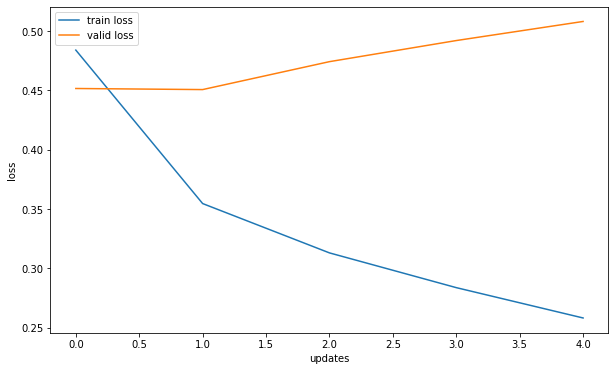

In [90]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

Text(0, 0.5, 'acc')

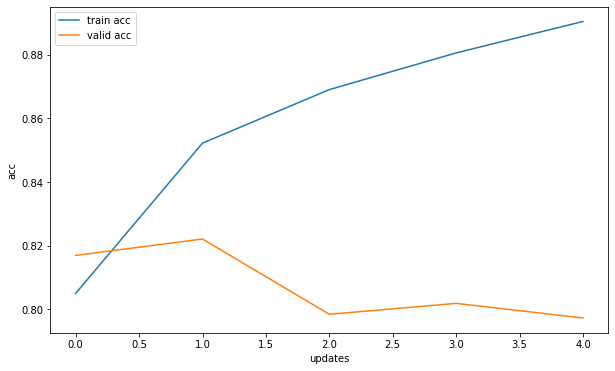

In [91]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_accs, label = 'train acc')
ax.plot(valid_accs, label = 'valid acc')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('acc')

In [92]:
model.load_state_dict(torch.load(save_path))

test_loss, test_acc = evaluate(model, test_loader, criterion, test_loader_length)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.461 | Test Acc: 81.79%


In [93]:
test_str_list = ["I love movie","I love to read with my friends"]
def prediction(test_str_list):
    result = list()
    for test_str in test_str_list:
        text = torch.tensor(text_pipeline(test_str)).to(device).reshape(1, -1)
        # text_list = [x.item() for x in text]
        text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1] #.detach().cpu().numpy()
        result.append((test_str, predicted))
    return result

In [94]:
prediction(test_str_list)

[('I love movie', tensor([3], device='cuda:0')),
 ('I love to read with my friends', tensor([3], device='cuda:0'))]